In [1]:
using Random
using Distributions
using FFTW
using LinearAlgebra 
using Arpack 
using Plots
using StatsBase
using StatsPlots
using LaTeXStrings

In [2]:
#L=100;  #system size
sigma=0.1; 
theta=pi;  #the twist
Nreal=2000;  #number of samples 

tk(n,sig,ll,th)=-sign(cos(2.0*pi*n/ll+th/ll))*abs(cos(2.0*pi*n/ll+th/ll))^sig; #k-space Hamiltonian

In [34]:
W=0.15
L=500

En=zeros(Nreal);           #initialize the vector of eigevalues 
Evec=zeros(Complex{Float64},L,Nreal);       #initialize the matrix of eigenvectors 
V=zeros(L,Nreal)                       #Matrix of random potential

Random.seed!(346)   #setting the seed

for ireal in 1:Nreal

    Vx = W.*randn(L)     #random potential 

    Vxx = sum(Vx)/L      # average of random potential 
    
    V[:,ireal]=Vx

    Hk = zeros(L)        #kinetic part of the Hamiltonian initialized with zeros

    for l in 1:L
        Hk[l] = tk(l,sigma,L,theta)
    end

    Hf = ifft(Hk)        #inverse Fourier transform of kinetic Hamiltonian

    H = zeros(Complex{Float64},L,L)   #real space Hamiltonian initialized with zeros

    for i in 1:L
        for j in 1:L
            if i==j
                H[i,j] = Vx[i] - Vxx
            elseif i>j
                H[i,j] = Hf[i-j+1]
            else
                H[i,j] = conj(Hf[j-i+1])
            end
        end
    end

    en0, evec0 = eigs(H, nev=1, which=:SM)
    
    En[ireal]=real(en0[1])
    Evec[:,ireal]=evec0[:,1]
    
end

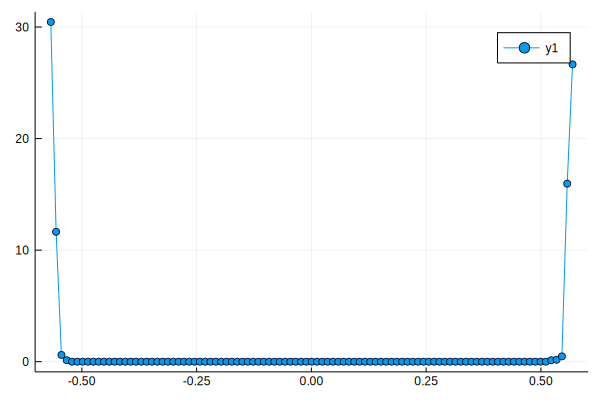

In [35]:
hs = normalize(fit(Histogram, En, LinRange(minimum(En),maximum(En),100)))
r = hs.edges[1]
x = first(r)+step(r)/2:step(r):last(r)
hsw = hs.weights 

plot(x, hsw, shape=:circle)

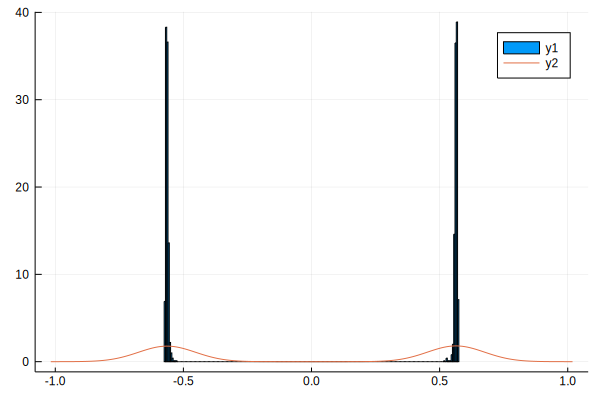

In [36]:
histogram(En,bins=500,normed=true)
density!(En)

In [37]:
rin = argmin(abs.(En))   #index or rare state

464

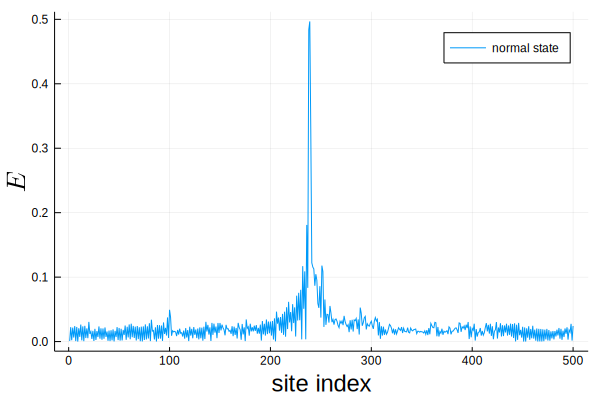

In [38]:
evr=Evec[:,rin];  #rare state
plot(abs.(evr),xlabel="site index",ylabel=L"E",label="normal state", xguidefontsize = 16, yguidefontsize = 18)

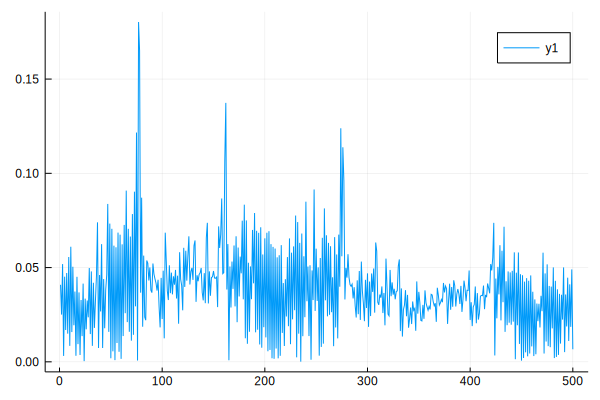

In [39]:
tin = argmin(abs.(En.-mean(abs.(En)))) # typical state index
evt=Evec[:,tin];          #typical eigenstate
plot(abs.(evt))

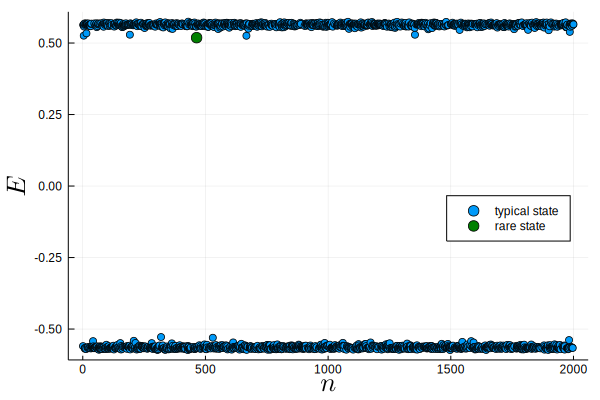

In [40]:
scatter(En,xlabel=L"n",ylabel=L"E",label="typical state",legend=:right, xguidefontsize = 18, yguidefontsize = 18)
scatter!([rin], [En[rin]], color = "green", label = "rare state", markersize = 6)

### Rare potential

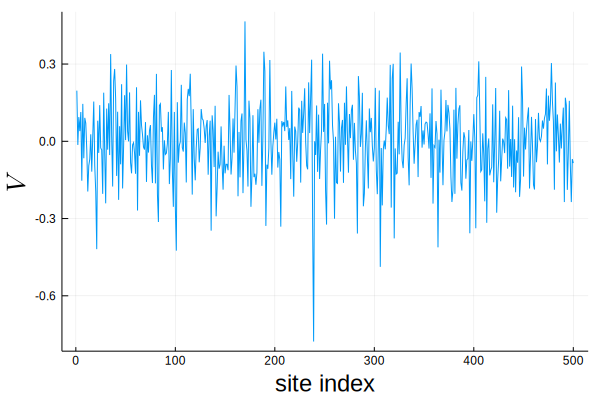

In [41]:
Vr = V[:,rin];
plot(Vr,xlabel="site index",ylabel=L"V", xguidefontsize = 16, yguidefontsize = 18,legend=:none)

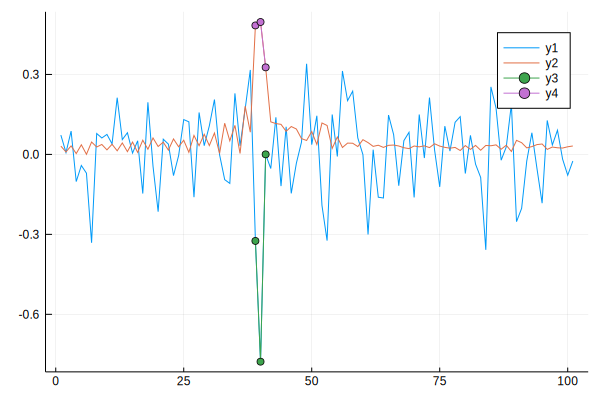

In [42]:
evr_max = argmax(abs.(evr))     #the index of maximum amplitude of rare state
plot(Vr[200:300])
plot!(abs.(evr)[200:300])
plot!([evr_max-200:1:evr_max+2-200;],Vr[evr_max-1:evr_max+1],shape=:circle)
plot!([evr_max-200:1:evr_max+2-200;],abs.(evr)[evr_max-1:evr_max+1],shape=:circle)

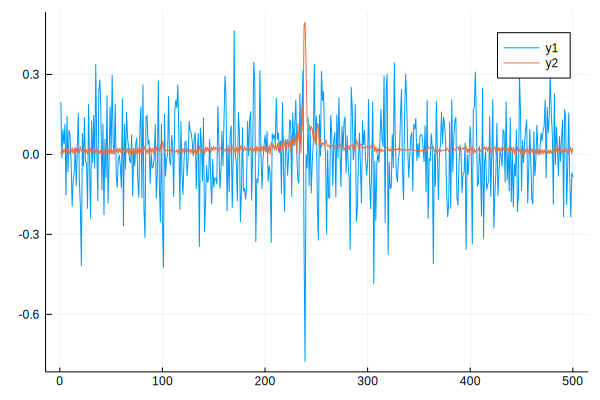

In [43]:
plot(Vr)
plot!(abs.(evr))

Generating the Hamiltonian for rare state

In [47]:
Vx = Vr     #random potential is the ireal'th column of the potential matrix V_new 

Vxx = sum(Vx)/L      # average of random potential 

Hk = zeros(L)        #kinetic part of the Hamiltonian initialized with zeros

for l in 1:L
    Hk[l] = tk(l,sigma,L,theta)
end

Hf = ifft(Hk)        #inverse Fourier transform of kinetic Hamiltonian

H_r = zeros(Complex{Float64},L,L)   #real space Hamiltonian initialized with zeros

for i in 1:L
    for j in 1:L
        if i==j
            H_r[i,j] = Vx[i] - Vxx
        elseif i>j
            H_r[i,j] = Hf[i-j+1]
        else
            H_r[i,j] = conj(Hf[j-i+1])
        end
    end
end 

### Manually tuning the rare potential

The potential around the mximum of wave amplitude

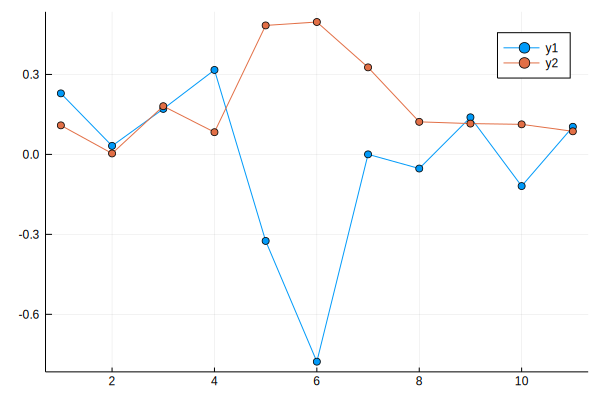

In [44]:
plot(Vr[evr_max-5:evr_max+5],shape=:circle)
plot!(abs.(evr)[evr_max-5:evr_max+5],shape=:circle)

In [45]:
### Manually tuning the rare potential

Vr_n=copy.(Vr);
Vr_n[evr_max]=Vr_n[evr_max]-1

-1.7776923238486506

Now the potential becomes

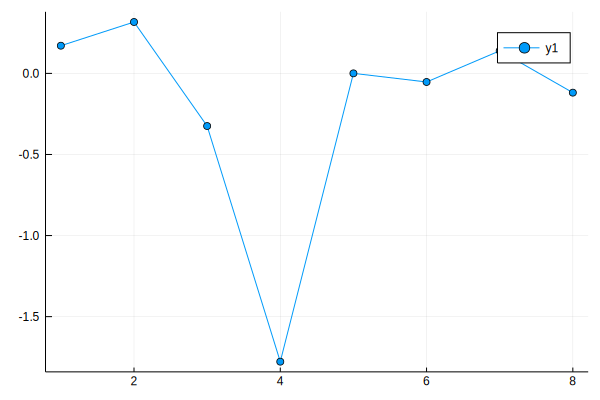

In [46]:
plot(Vr_n[evr_max-3:evr_max+4],shape=:circle)

Udate the rate state and rare energy. We can directly update the diagonal element corresponding to the updated potential. 

In [61]:
Hr_n = copy(H_r)
Hr_n[evr_max,evr_max]=Hr_n[evr_max,evr_max]-1

en0, evec0 = eigs(Hr_n, nev=1, which=:SM)

Evr_n = evec0[:,1]

Enr_n = real(en0[1])

0.3070731764102624

In [58]:
#update the energy spectrum
En_n = copy.(En);
En_n[rin] = Enr_n

0.30707317641026116

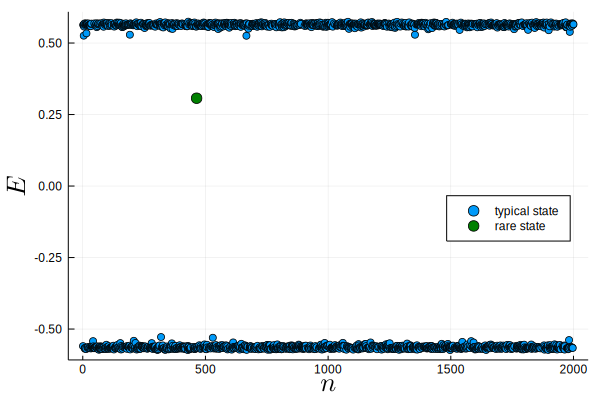

In [59]:
scatter(En_n,xlabel=L"n",ylabel=L"E",label="typical state",legend=:right, xguidefontsize = 18, yguidefontsize = 18)
scatter!([rin], [En_n[rin]], color = "green", label = "rare state", markersize = 6)

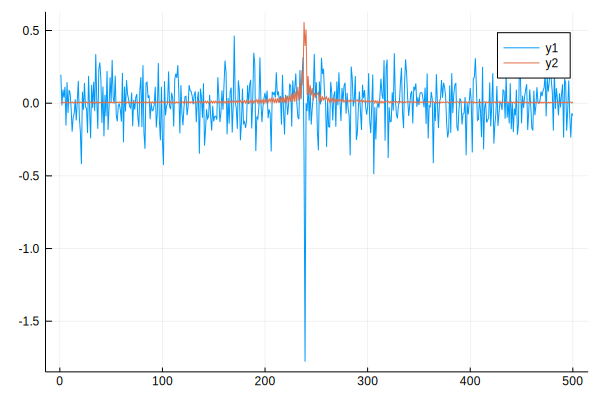

In [62]:
plot(real(diag(Hr_n)))
plot!(abs.(Evr_n))

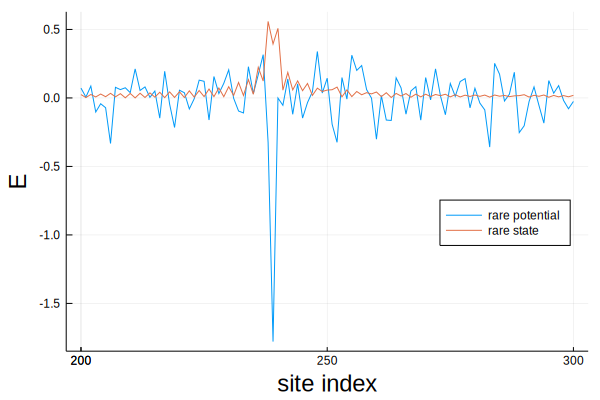

In [63]:
plot([200:1:300;],real(diag(Hr_n))[200:300],label="rare potential", legend=:right, xlabel="site index", ylabel="E", xguidefontsize=16,
yguidefontsize=16)
plot!([200:1:300;],abs.(Evr_n)[200:300], label="rare state")

Now I want to extract several other states (other thant smallest magnitute eigenvalue) from the same sample.

In [64]:
F = eigen(Hr_n);

#Evr_n = evec0[:,1]

#Enr_n = real(en0[1])

In [65]:
argmin(abs.(F.values))

251

In [66]:
F.values[argmin(abs.(F.values))]

0.30707317641026266

In [67]:
F.values[argmin(abs.(F.values))-2:argmin(abs.(F.values))+2]

5-element Vector{Float64}:
 -0.581499366536979
 -0.5700355035887328
  0.30707317641026266
  0.5679488360670265
  0.5817385541817444

Now I want to have a set of tuning strengths of local potential, and corresponding rare eigen energy. 

In [69]:
Vt = [-10:0.5:10;]

Enr_new = zeros(length(Vt),5) 

#Evr_new = zeros(Complex{Float64},L,length(Vt));

for i in 1:length(Vt) 
    
    Hr = copy(H_r)
    Hr[evr_max,evr_max]=Hr[evr_max,evr_max]+Vt[i]

    F = eigen(Hr)

#    Evr_new[:,i] = evec0[:,1]
    
    r=argmin(abs.(F.values))

    Enr_new[i,:] =  [F.values[r], F.values[r-1], F.values[r+1], F.values[150], F.values[450]]        #F.values[argmin(abs.(F.values))-2:argmin(abs.(F.values))+2]

end

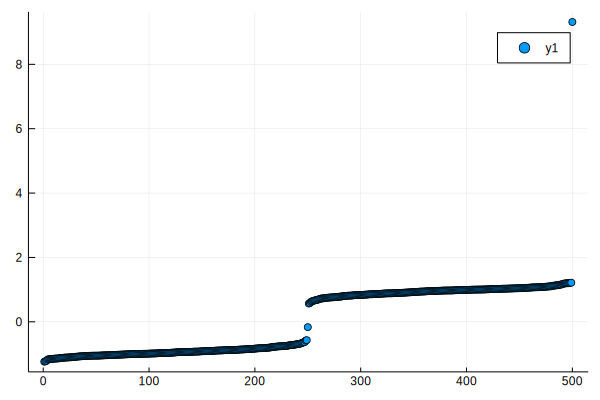

In [70]:
scatter(F.values)

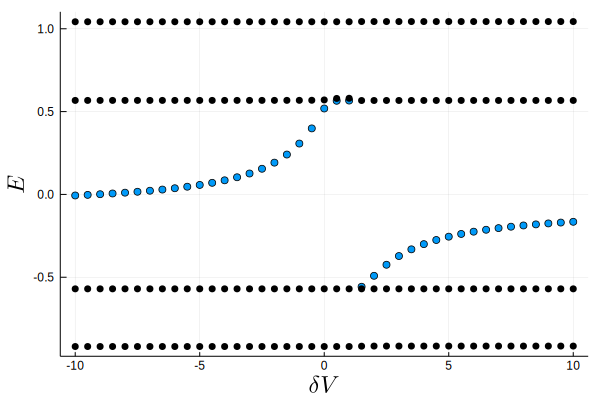

In [71]:
scatter(Vt,Enr_new[:,1],legend=:false,xlabel=L"\delta V", ylabel=L"E",xguidefontsize=16,yguidefontsize=16)
scatter!(Vt,Enr_new[:,2],color=:black)
scatter!(Vt,Enr_new[:,3],color=:black)
scatter!(Vt,Enr_new[:,4],color=:black)
scatter!(Vt,Enr_new[:,5],color=:black)

Now I want to change the values of potential at three neighboring sites, centring at the peak position of wave function.

In [85]:
Vt = [-10:0.5:10;]

Enr_new1 = zeros(length(Vt),5) 

#Evr_new = zeros(Complex{Float64},L,length(Vt));

for i in 1:length(Vt) 
    
    Hr=copy(H_r);
    Hr[evr_max-1:evr_max+1,evr_max-1:evr_max+1]=Hr[evr_max-1:evr_max+1,evr_max-1:evr_max+1].-Vt[i];

    F = eigen(Hr)

#    Evr_new[:,i] = evec0[:,1]
    
    r=argmin(abs.(F.values))

    Enr_new1[i,:] =  [F.values[r], F.values[r-1], F.values[r+1], F.values[150], F.values[450]]        #F.values[argmin(abs.(F.values))-2:argmin(abs.(F.values))+2]

end

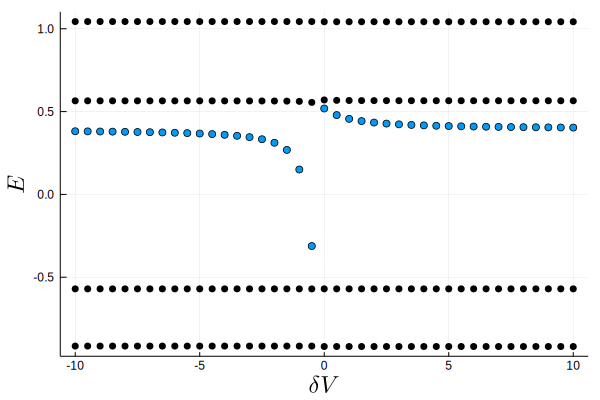

In [86]:
scatter(Vt,Enr_new1[:,1],legend=:false,xlabel=L"\delta V", ylabel=L"E",xguidefontsize=16,yguidefontsize=16)
scatter!(Vt,Enr_new1[:,2],color=:black)
scatter!(Vt,Enr_new1[:,3],color=:black)
scatter!(Vt,Enr_new1[:,4],color=:black)
scatter!(Vt,Enr_new1[:,5],color=:black)

In [88]:
Vt2 = [-3:0.1:3;]

Enr_new2 = zeros(length(Vt2),5) 

Evr_n2 = zeros(Complex{Float64},L,length(Vt2))

#Evr_new = zeros(Complex{Float64},L,length(Vt));

for i in 1:length(Vt2) 
    
    Hr=copy(H_r);
    Hr[evr_max-1:evr_max+1,evr_max-1:evr_max+1]=Hr[evr_max-1:evr_max+1,evr_max-1:evr_max+1].-Vt2[i];

    F = eigen(Hr)

#    Evr_new[:,i] = evec0[:,1]
    
    r=argmin(abs.(F.values))
    
    Evr_n2[:,i] = F.vectors[:,r]

    Enr_new2[i,:] =  [F.values[r], F.values[r-2], F.values[r+2], F.values[150], F.values[450]]        #F.values[argmin(abs.(F.values))-2:argmin(abs.(F.values))+2]

end

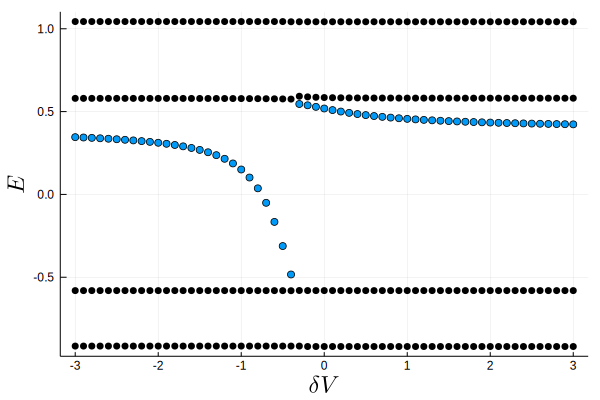

In [89]:
scatter(Vt2,Enr_new2[:,1],legend=:false,xlabel=L"\delta V", ylabel=L"E",xguidefontsize=16,yguidefontsize=16)
scatter!(Vt2,Enr_new2[:,2],color=:black)
scatter!(Vt2,Enr_new2[:,3],color=:black)
scatter!(Vt2,Enr_new2[:,4],color=:black)
scatter!(Vt2,Enr_new2[:,5],color=:black)

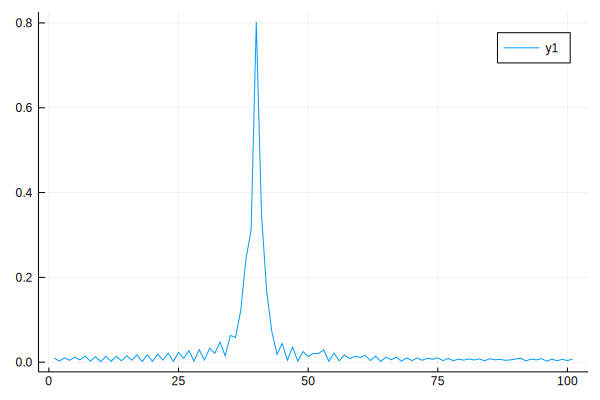

In [90]:
plot(abs.(Evr_n2[:,1])[200:300])

In [160]:
vt2_min=argmin(abs.(Enr_new2[:,1]))

23

In [161]:
Enr_new2[vt2_min]

0.03680812391135868

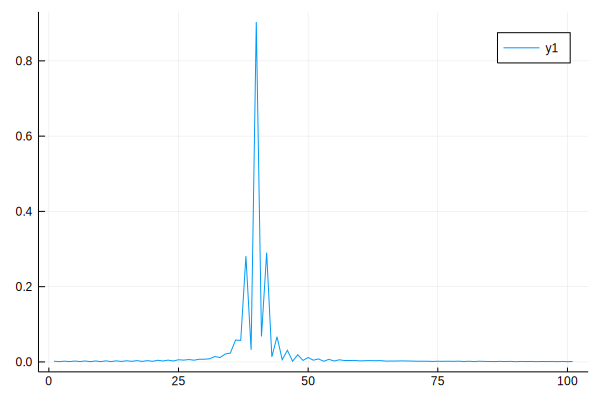

In [162]:
plot(abs.(Evr_n2[:,vt2_min])[200:300])

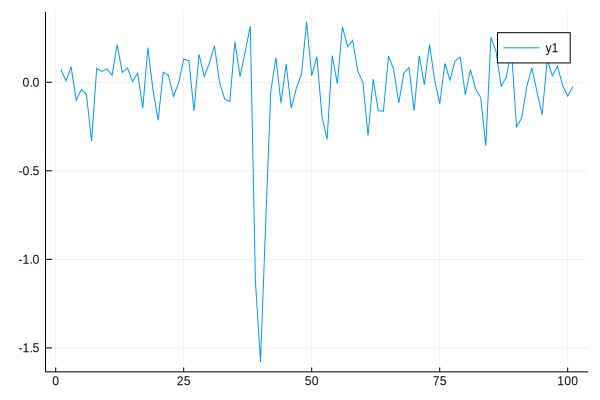

In [163]:
Vr_new2 = copy.(Vr)
    
Vr_new2[evr_max-1:evr_max+1]=Vr_new2[evr_max-1:evr_max+1].+Vt2[vt2_min]

plot(Vr_new2[200:300])

Trying to change the the potential of two neighborinh site in opposite direction. 

In [146]:
Vt3 = [-3:0.1:3;]

Enr_new3 = zeros(length(Vt3),5) 

Evr_n3 = zeros(Complex{Float64},L,length(Vt3))

#Evr_new = zeros(Complex{Float64},L,length(Vt));

for i in 1:length(Vt3) 
    
    Hr = copy.(H_r)
    
    Hr[evr_max-1,evr_max-1]=Hr[evr_max-1,evr_max-1]-Vt3[i]
    
    Hr[evr_max,evr_max]=Hr[evr_max,evr_max]+Vt3[i]
    
    Hr[evr_max+1,evr_max+1]=Hr[evr_max+1,evr_max+1]-Vt3[i]

    F = eigen(Hr)

#    Evr_new[:,i] = evec0[:,1]
    
    r=argmin(abs.(F.values))
    
    Evr_n3[:,i] = F.vectors[:,r]

    Enr_new3[i,:] =  [F.values[r], F.values[r-2], F.values[r+2], F.values[150], F.values[450]]        #F.values[argmin(abs.(F.values))-2:argmin(abs.(F.values))+2]

end

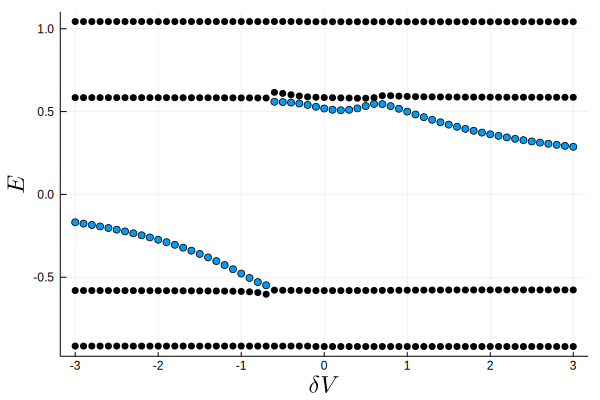

In [147]:
scatter(Vt3,Enr_new3[:,1],legend=:false,xlabel=L"\delta V", ylabel=L"E",xguidefontsize=16,yguidefontsize=16)
scatter!(Vt3,Enr_new3[:,2],color=:black)
scatter!(Vt3,Enr_new3[:,3],color=:black)
scatter!(Vt3,Enr_new3[:,4],color=:black)
scatter!(Vt3,Enr_new3[:,5],color=:black)

In [156]:
vt3_min = argmin(abs.(Enr_new3[:,1]))

1

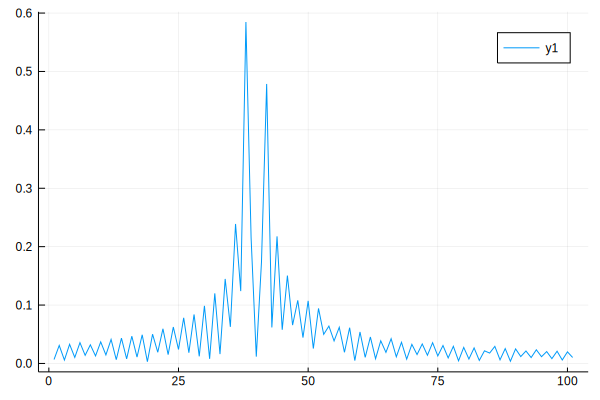

In [157]:
plot(abs.(Evr_n3[:,vt3_min])[200:300])

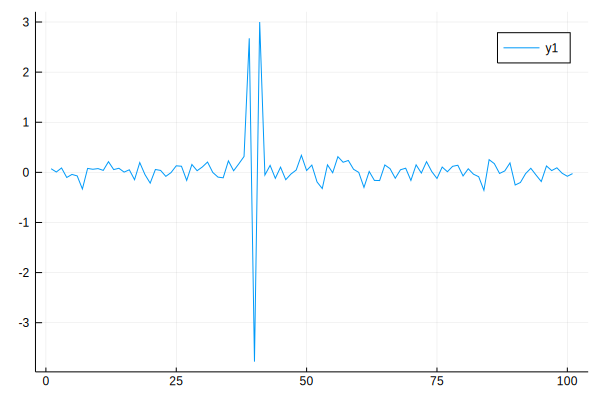

In [158]:
Vr_new3 = copy.(Vr)
    
Vr_new3[evr_max-1]=Vr_new3[evr_max-1].-Vt2[vt3_min]
    
Vr_new3[evr_max]=Vr_new3[evr_max].+Vt2[vt3_min]
    
Vr_new3[evr_max+1]=Vr_new3[evr_max+1].-Vt2[vt3_min]

plot(Vr_new3[200:300])

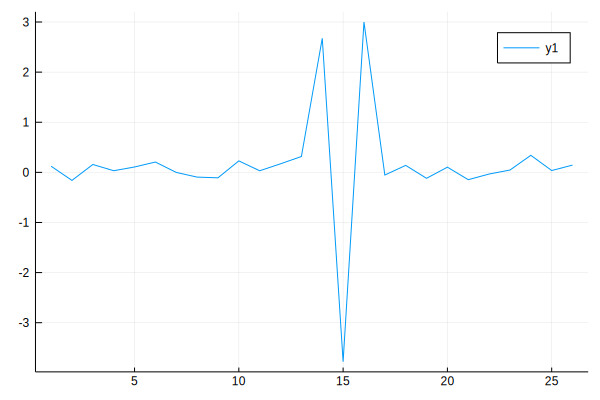

In [159]:
plot(Vr_new3[225:250])

In [141]:
Vt4 = [-3:0.1:3;]

Enr_new4 = zeros(length(Vt4),5) 

Evr_n4 = zeros(Complex{Float64},L,length(Vt4))

#Evr_new = zeros(Complex{Float64},L,length(Vt));

for i in 1:length(Vt4) 
    
    Hr = copy.(H_r)
    
    Hr[evr_max-1,evr_max-1]=Hr[evr_max-1,evr_max-1]-0.5*Vt4[i]
    
    Hr[evr_max,evr_max]=Hr[evr_max,evr_max]+Vt4[i]
    
    Hr[evr_max+1,evr_max+1]=Hr[evr_max+1,evr_max+1]+Vt4[i]
    
    Hr[evr_max+2,evr_max+2]=Hr[evr_max+2,evr_max+2]-0.5*Vt4[i]

    F = eigen(Hr)

#    Evr_new[:,i] = evec0[:,1]
    
    r=argmin(abs.(F.values))
    
    Evr_n4[:,i] = F.vectors[:,r]

    Enr_new4[i,:] =  [F.values[r], F.values[r-2], F.values[r+2], F.values[150], F.values[450]]        #F.values[argmin(abs.(F.values))-2:argmin(abs.(F.values))+2]

end

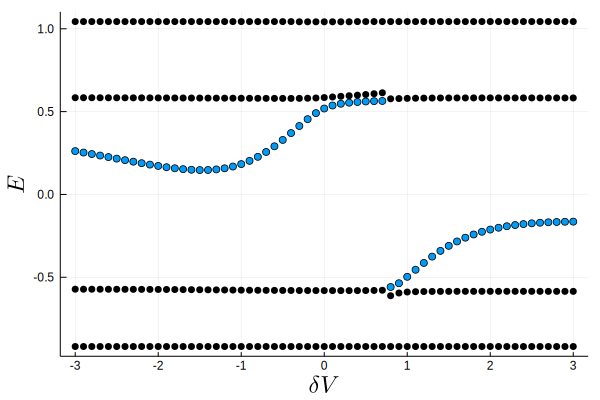

In [142]:
scatter(Vt4,Enr_new4[:,1],legend=:false,xlabel=L"\delta V", ylabel=L"E",xguidefontsize=16,yguidefontsize=16)
scatter!(Vt4,Enr_new4[:,2],color=:black)
scatter!(Vt4,Enr_new4[:,3],color=:black)
scatter!(Vt4,Enr_new4[:,4],color=:black)
scatter!(Vt4,Enr_new4[:,5],color=:black)

In [143]:
vt_min = argmin(abs.(Enr_new4[:,1]))

16

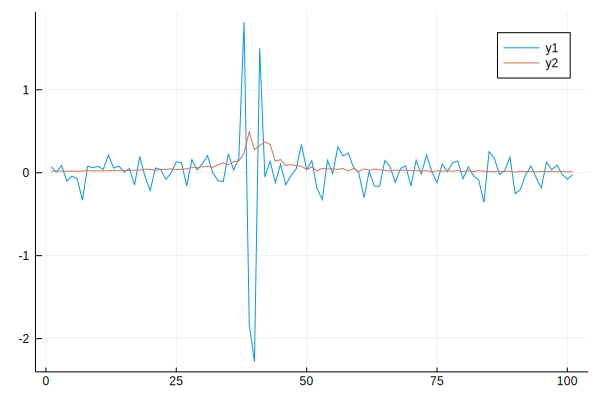

In [144]:
Vr_new4 = copy.(Vr)
    
Vr_new4[evr_max-2]=Vr_new4[evr_max-2].-Vt2[vt_min]

Vr_new4[evr_max-1]=Vr_new4[evr_max-1].+Vt2[vt_min]

Vr_new4[evr_max]=Vr_new4[evr_max].+Vt2[vt_min]
    
Vr_new4[evr_max+1]=Vr_new4[evr_max+1].-Vt2[vt_min]

plot(Vr_new4[200:300])
plot!(abs.(Evr_n4[:, vt_min])[200:300])

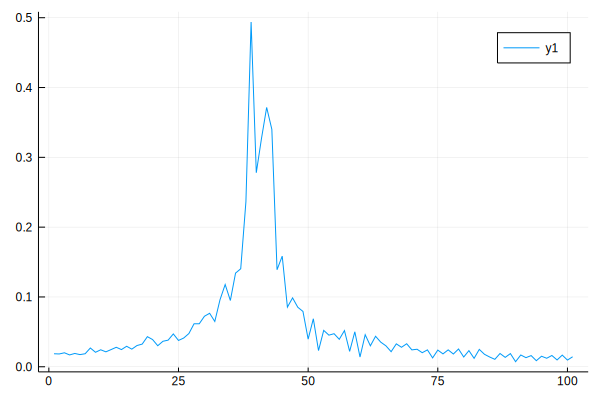

In [164]:
plot(abs.(Evr_n4[:, vt_min])[200:300])